In [1]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [19]:
class textPieces(): 
    def __init__(self, author, sample=True, pieces=2): 
        self.author = author
        self.filenames = glob('data/%s*' % author)
        print('Using filenames: ', self.filenames)
        self.texts = [open(filename, errors="ignore").read() 
                 for filename in self.filenames]
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.labels = []
            self.pieces = []
            self.makePieces(self.filenames, self.samples, 2)
        else: 
            self.labels = [filename[6+len(self.author):-4] for filename in self.filenames]
            self.pieces = self.texts
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            print('Something went wrong. maxEnd is negative or zero.')
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, filenames, samples, n): 
        pieceSize = self.lowestLength / n
        for filename, sample in zip(filenames, samples): 
            for i in range(n):
                label = filename[6+len(self.author):-4] # Cut off 'data/cather-' for example and .txt
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [32]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        
    #@property
    #def categories(): 
    #    pass
        
    def vectorize(self): 
        tfidf = TfidfVectorizer(use_idf=False, max_features=400)
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
    
    def doTSNE(self): 
        tSNE = TSNE(n_components=2)
        return tSNE.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
        print('Adjusted rand score, Kmeans: ', randK)
        print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
        print('Adjusted mutual info score, Kmeans: ', randK)
        print('Adjusted mutual info score, BGM: ', randB)

In [36]:
def doAnalysis(author):  
    pieces = textPieces(author)
    analysis = authorAnalysis(pieces.labels, pieces.pieces)
    print(analysis.plotPCA(saveTo=author))
    print(analysis.metrics())

# Proust

Using filenames:  ['data/proust-1920-guermantes.txt', 'data/proust-1919-lombre.txt', 'data/proust-1927-retrouve.txt', 'data/proust-1923-prisonniere.txt', 'data/proust-1921-sodome.txt', 'data/proust-1925-albertine.txt', 'data/proust-1913-swann.txt']
Something went wrong. maxEnd is negative or zero.
                           0         1         2         3         4  distance
1913-swann-1        0.249775  0.144673 -0.023762  0.016907 -0.005886  0.288648
1925-albertine-0   -0.170037  0.118063 -0.039371  0.011906 -0.041142  0.207006
1923-prisonniere-1 -0.091683  0.076330  0.073966  0.005547  0.000360  0.119298
1919-lombre-1       0.017532 -0.095302 -0.019954 -0.050759 -0.022746  0.096902
1927-retrouve-0     0.015282 -0.092125 -0.006195  0.083807 -0.027062  0.093384
1913-swann-0        0.065889 -0.043180 -0.047182 -0.035100 -0.009183  0.078777
1921-sodome-1       0.033311 -0.046433  0.120988  0.034665  0.008428  0.057146
1927-retrouve-1    -0.020965 -0.050742 -0.088451  0.015686  0.017817 

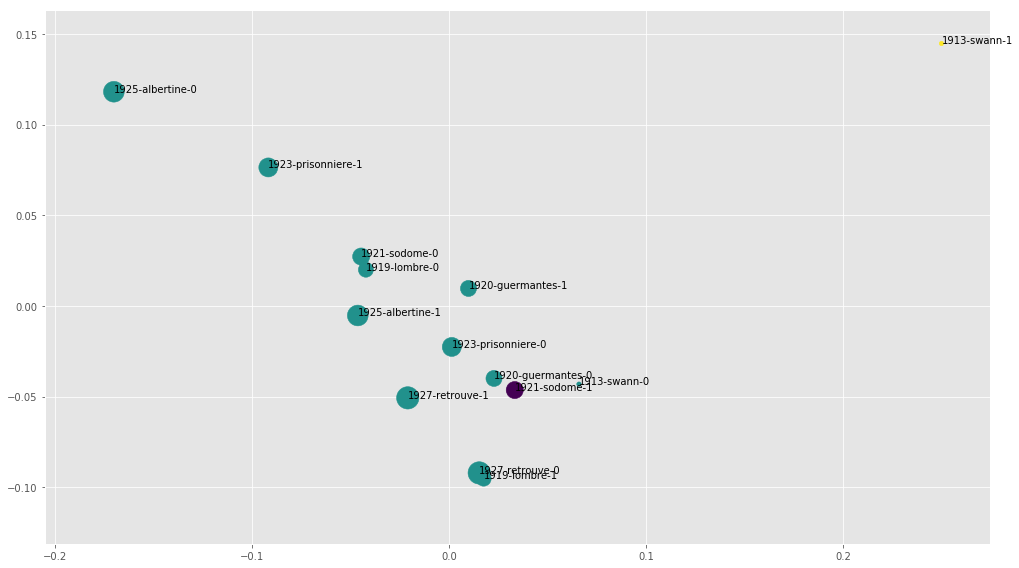

In [40]:
doAnalysis('proust')

# Dickens

Using filenames:  ['data/dickens-1839-oliver-twist.txt', 'data/dickens-1865-our-mutual-friend.txt', 'data/dickens-1859-a-tale-of-two-cities.txt', 'data/dickens-1850-david-copperfield.txt', 'data/dickens-1861-great-expectations.txt', 'data/dickens-1870-the-mystery-of-edwin-drood.txt', 'data/dickens-1848-dombey-and-son.txt', 'data/dickens-1841-the-old-curiosity-shop.txt', 'data/dickens-1854-hard-times.txt', 'data/dickens-1844-martin-chuzzlewit.txt', 'data/dickens-1857-little-dorrit.txt', 'data/dickens-1841-barnaby-rudge.txt', 'data/dickens-1837-the-pickwick-papers.txt', 'data/dickens-1839-nicholas-nickleby.txt', 'data/dickens-1853-bleak-house.txt']
Something went wrong. maxEnd is negative or zero.
                                          0         1         2         3  \
1837-the-pickwick-papers-1        -0.172210  0.173170  0.068791 -0.030270   
1837-the-pickwick-papers-0        -0.194457  0.138333  0.075976 -0.010603   
1850-david-copperfield-1           0.203747  0.009684  0.116415 

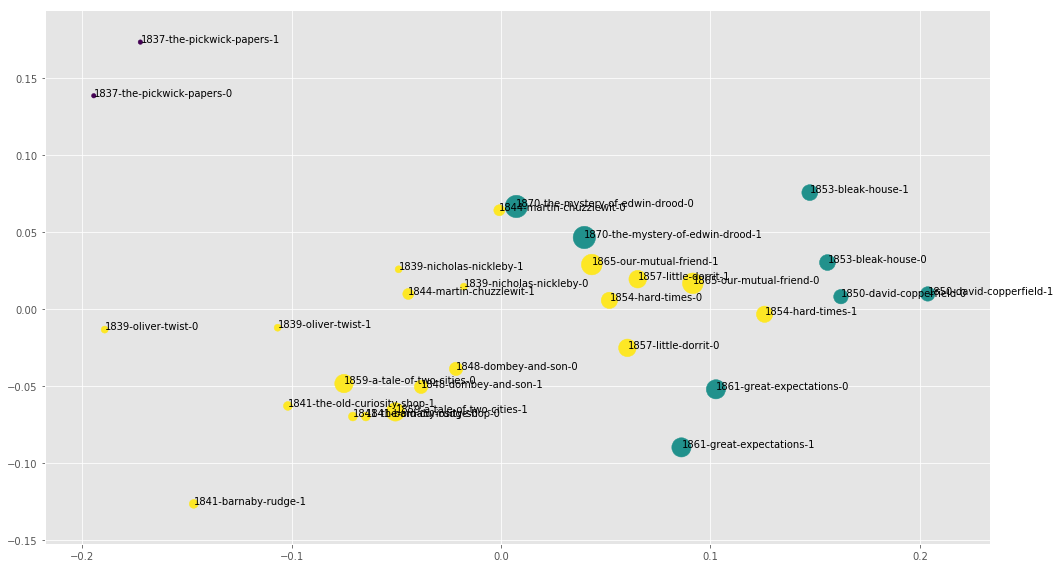

In [41]:
doAnalysis('dickens')

# Conrad

Using filenames:  ['data/conrad-1897-the-nigger-of-the-narcissus.txt', 'data/conrad-1907-the-secret-agent.txt', 'data/conrad-1911-under-western-eyes.txt', 'data/conrad-1895-almayers-folly.txt', 'data/conrad-1900-lord-jim.txt', 'data/conrad-1902-typhoon.txt', 'data/conrad-1920-the-rescue.txt', 'data/conrad-1919-the-arrow-of-gold.txt', 'data/conrad-1925-suspense.txt', 'data/conrad-1896-an-outcast-of-the-islands.txt', 'data/conrad-1899-heart-of-darkness.txt', 'data/conrad-1913-chance.txt', 'data/conrad-1923-the-rover.txt', 'data/conrad-1902-the-end-of-the-tether.txt', 'data/conrad-1917-the-shadow-line.txt', 'data/conrad-1904-nostromo.txt', 'data/conrad-1915-victory.txt']
Something went wrong. maxEnd is negative or zero.
                                           0         1         2         3  \
1919-the-arrow-of-gold-0            0.286436 -0.105742  0.065554  0.120869   
1895-almayers-folly-0              -0.203426 -0.143381 -0.011649  0.057676   
1904-nostromo-0                    -0.1

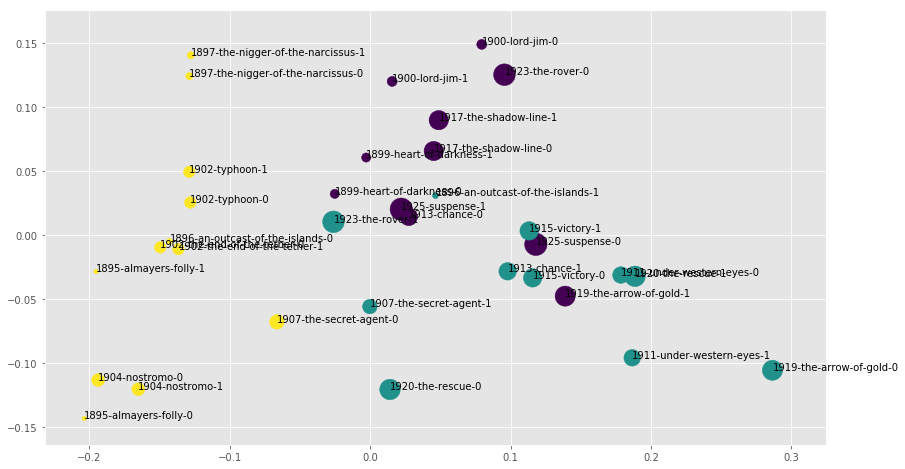

In [31]:
doAnalysis('conrad')

# Jean Genet

Using filenames:  ['data/genet-1986-captif-amoreux.txt', 'data/genet-1947-pompes-funèbres.txt', 'data/genet-1949-journal-du-voleur.txt', 'data/genet-1947-querelle-de-brest.txt', 'data/genet-1946-miracle-de-la-rose.txt', 'data/genet-1942-notre-dame.txt']
Something went wrong. maxEnd is negative or zero.
                                  0         1         2         3         4  \
1947-querelle-de-brest-0   0.204739 -0.057204 -0.066925 -0.006724  0.004896   
1947-querelle-de-brest-1   0.184614 -0.092705 -0.053904 -0.063251 -0.029579   
1986-captif-amoreux-0     -0.058753  0.195643 -0.070959  0.001691 -0.019389   
1949-journal-du-voleur-1  -0.150837 -0.135549  0.023929 -0.032410 -0.044987   
1949-journal-du-voleur-0  -0.185835 -0.069555  0.009466  0.005220 -0.052332   
1986-captif-amoreux-1     -0.081038  0.138324 -0.067132 -0.002628 -0.013861   
1942-notre-dame-1          0.084224  0.102165  0.104232 -0.028222 -0.003552   
1942-notre-dame-0          0.085322  0.075918  0.116608 -0.01237

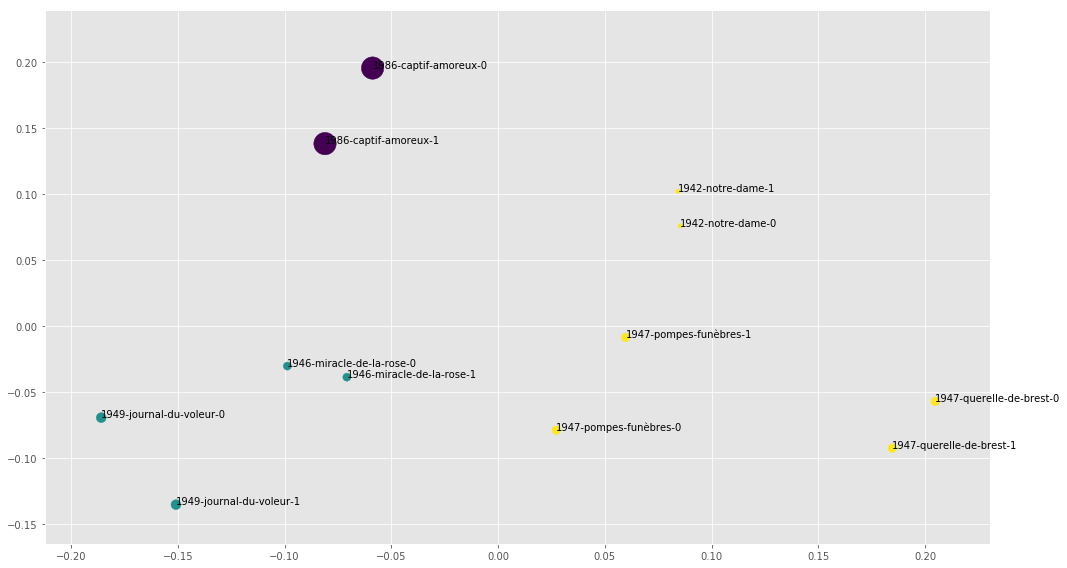

In [42]:
doAnalysis('genet')

# Hemingway

Using filenames:  ['data/hemingway-1926-torrents-spring.txt', 'data/hemingway-1986-garden-of-eden.txt', 'data/hemingway-1937-to-have-and-have.txt', 'data/hemingway-1926-sun-also-rises.txt', 'data/hemingway-1940-for-whom-the-bell.txt', 'data/hemingway-1952-old-man-and-the-sea.txt', 'data/hemingway-1936-short-happy.txt', 'data/hemingway-1929-farewell-to-arms.txt', 'data/hemingway-1950-across-the-river.txt', 'data/hemingway-1970-islands-in-the-stream.txt']
Something went wrong. maxEnd is negative or zero.
                                     0         1         2         3  \
1926-torrents-spring-0        0.438572 -0.161451  0.033670  0.270542   
1926-torrents-spring-1        0.331491 -0.171226 -0.004117  0.088460   
1940-for-whom-the-bell-0     -0.023204  0.326654  0.390486  0.088748   
1952-old-man-and-the-sea-1    0.201431  0.223446 -0.111293 -0.121355   
1952-old-man-and-the-sea-0    0.193999  0.161251 -0.110565 -0.139131   
1986-garden-of-eden-1        -0.178157  0.171592 -0.262290  

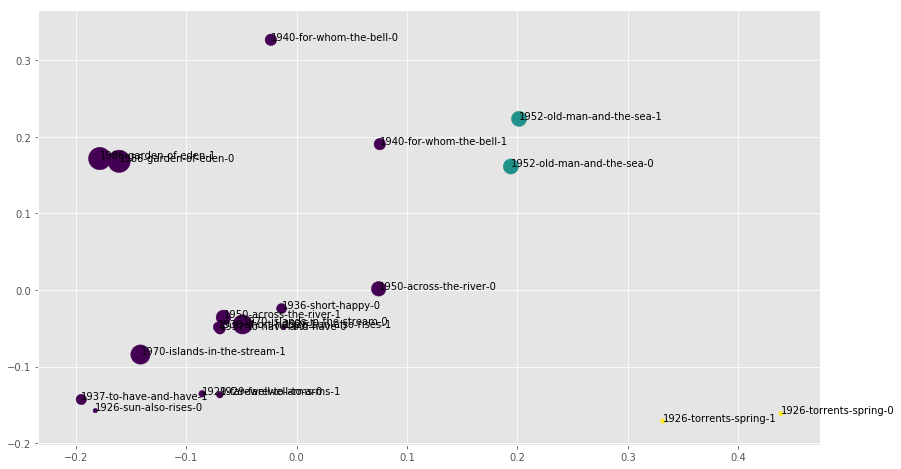

In [14]:
doAnalysis('hemingway')

In [16]:
# James

Using filenames:  ['data/james-1875-roderick-hudson.txt', 'data/james-1877-the-american.txt', 'data/james-1878-the-europeans.txt', 'data/james-1886-princess-casamassima.txt', 'data/james-1897-spoils-poynton.txt', 'data/james-1881-portrait-of-a-lady.txt', 'data/james-1911-outcry.txt', 'data/james-1904-golden-bowl.txt', 'data/james-1901-sacred-found.txt', 'data/james-1871-watch-and-ward.txt', 'data/james-1880-washington-square.txt', 'data/james-1886-bostonians.txt', 'data/james-1902-wings-of-the-dove.txt', 'data/james-1899-awkward-age.txt', 'data/james-1917-ivory-tower.txt', 'data/james-1897-what-maisie-knew.txt', 'data/james-1903-ambassadors.txt', 'data/james-1879-confidence.txt', 'data/james-1890-tragic-muse.txt', 'data/james-1888-reverberator.txt']
Something went wrong. maxEnd is negative or zero.
                                    0         1         2         3         4  \
1877-the-american-1          0.378000  0.327053 -0.135630 -0.122692 -0.213369   
1877-the-american-0         

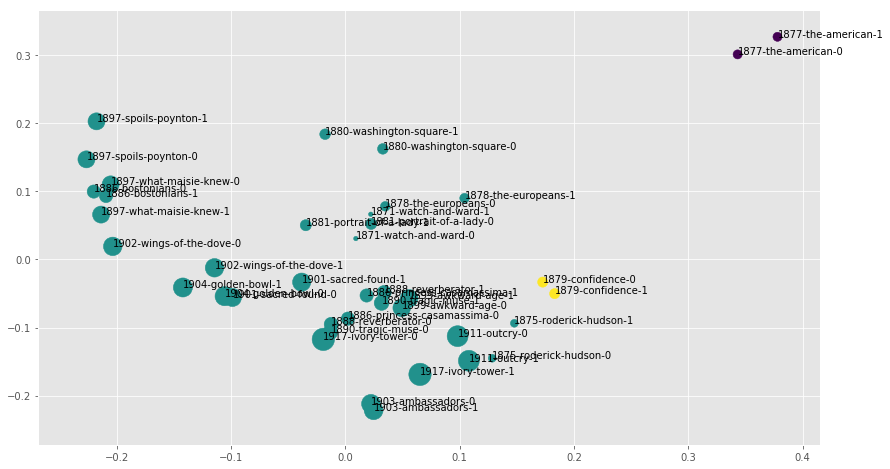

In [17]:
doAnalysis('james')

Using filenames:  ['data/mann-1903-tristan.txt', 'data/mann-1903-tonio.txt', 'data/mann-1897-kleine-herr.txt', 'data/mann-1909-königliche.txt', 'data/mann-1943-doktor.txt', 'data/mann-1912-tod.txt', 'data/mann-1902-gladius.txt', 'data/mann-1901-buddenbrooks.txt']
Something went wrong. maxEnd is negative or zero.
                            0         1         2         3         4  \
1897-kleine-herr-1   0.333298 -0.251925  0.067743  0.055688 -0.025099   
1897-kleine-herr-0   0.371264 -0.140670  0.005963  0.002012  0.051661   
1903-tristan-0       0.217025  0.310324 -0.078141 -0.011105 -0.005683   
1912-tod-0          -0.236876 -0.109647 -0.102784  0.018516  0.135360   
1903-tristan-1       0.157009  0.191001 -0.072062  0.015170  0.093184   
1912-tod-1          -0.209869 -0.119215 -0.036349 -0.002614  0.059766   
1909-königliche-1   -0.083452  0.140328  0.066997  0.127897 -0.015777   
1909-königliche-0   -0.112141  0.031890  0.164298  0.208680 -0.023986   
1903-tonio-1        -0.102341

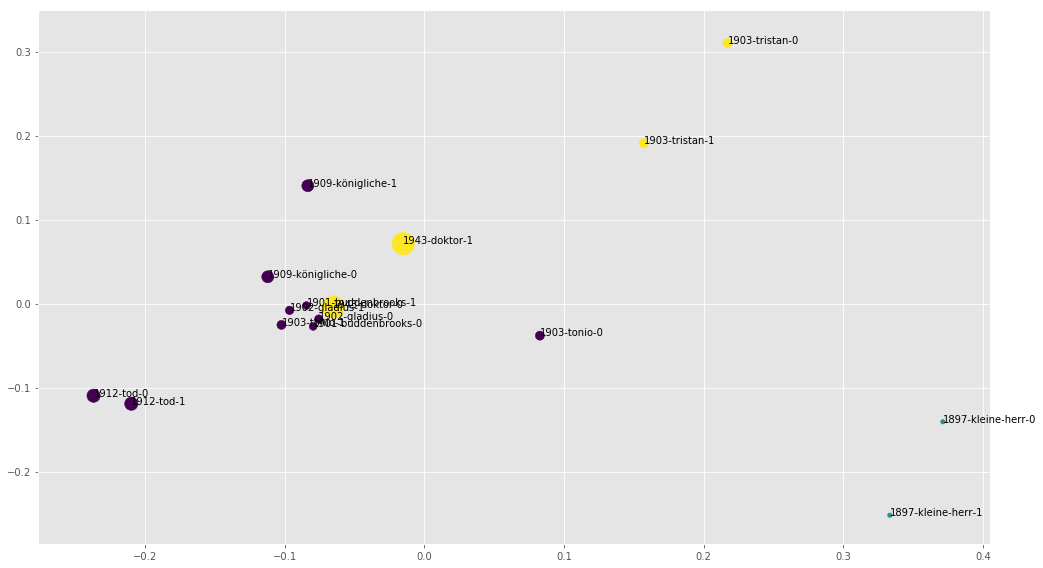

In [43]:
doAnalysis('mann')

Using filenames:  ['data/scott-1815-guy-mannering.txt', 'data/scott-1825-talisman.txt', 'data/scott-1828-maid-of-perth.txt', 'data/scott-1829-anne.txt', 'data/scott-1818-heart-of-midlothian.txt', 'data/scott-1824-redgauntlet.txt', 'data/scott-1814-waverly.txt', 'data/scott-1832-count-robert.txt', 'data/scott-1816-old-mortality.txt', 'data/scott-1819-legend-of-montrose.txt', 'data/scott-1816-black-dwarf.txt', 'data/scott-1819-ivanhoe.txt', 'data/scott-1820-the-abbot.txt', 'data/scott-1823-quentin.txt', 'data/scott-1821-pirate.txt', 'data/scott-1816-antiquary.txt', 'data/scott-1817-rob-roy.txt', 'data/scott-1821-kenilworth.txt', 'data/scott-1825-bethrothed.txt', 'data/scott-1826-woodstock.txt', 'data/scott-1823-st-ronans-well.txt', 'data/scott-1819-bride-of-lammermoor.txt', 'data/scott-1816-old-mortality.tt', 'data/scott-1831-castle-dangerous.txt']
Something went wrong. maxEnd is negative or zero.
                                   0         1         2         3         4  \
1817-rob-ro

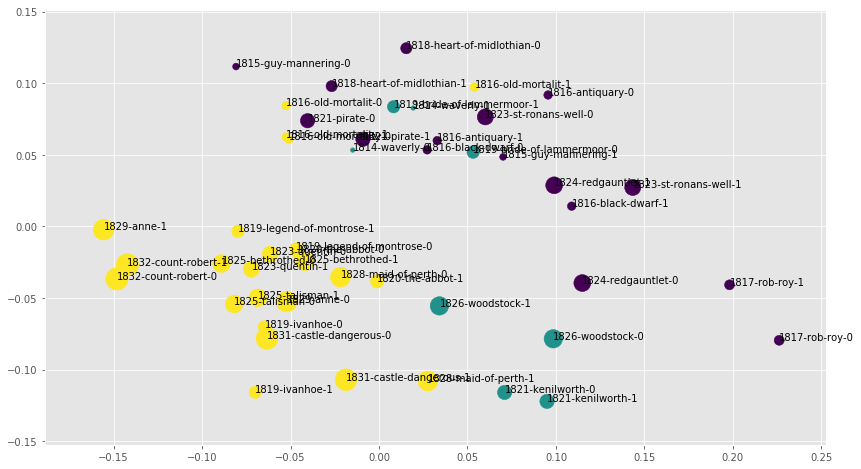

In [21]:
doAnalysis('scott')

Using filenames:  ['data/ward-1913-mating.txt', 'data/ward-1917-missing.txt', 'data/ward-1900-eleanor.txt', 'data/ward-1888-robert.txt', 'data/ward-1915-success.txt', 'data/ward-1908-diana.txt', 'data/ward-1881-milly.txt', 'data/ward-1903-lady-rose.txt', 'data/ward-1916-connie.txt', 'data/ward-1892-grieve.txt', 'data/ward-1898-helbeck.txt', 'data/ward-1896-tressady.txt', 'data/ward-1920-harvest.txt', 'data/ward-1894-marcella.txt', 'data/ward-1905-marriage.txt']
Something went wrong. maxEnd is negative or zero.
                         0         1         2         3         4  distance
1881-milly-0      0.602926 -0.003153  0.015208 -0.012032  0.003424  0.602935
1881-milly-1      0.500865 -0.020626 -0.000259 -0.008690 -0.008541  0.501289
1915-success-1   -0.013471  0.469467 -0.094282 -0.018495 -0.003039  0.469660
1915-success-0   -0.040360  0.403979 -0.127022 -0.010642 -0.033073  0.405990
1903-lady-rose-0 -0.051182  0.093385  0.402921 -0.106961 -0.035408  0.106492
1908-diana-1     -0.04

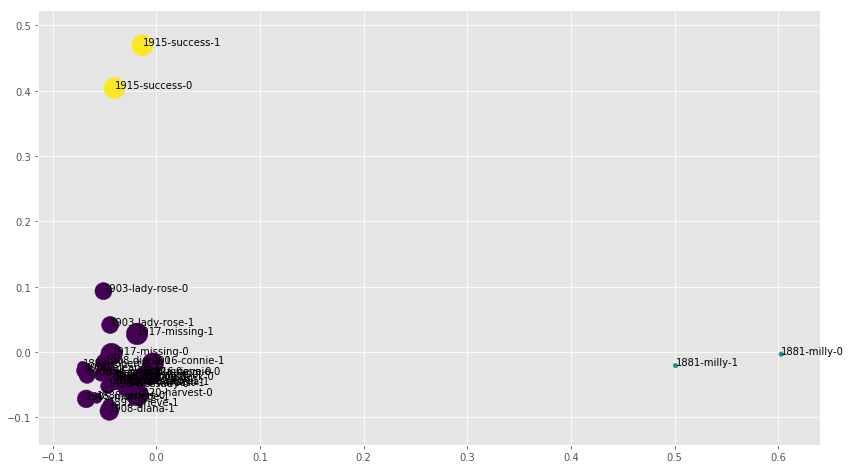

In [22]:
doAnalysis('ward')

Using filenames:  ['data/meredith-1877-the-case-of-general-ople-and-lady-camper.txt', 'data/meredith-1895-the-amazing-marriage.txt', 'data/meredith-1880-the-tragic-comedians.txt', 'data/meredith-1861-evan-harrington.txt', 'data/meredith-1877-the-house-on-the-beach.txt', 'data/meredith-1871-the-adventures-of-harry-richmond.txt', 'data/meredith-1859-the-ordeal-of-richard-feverel.txt', 'data/meredith-1910-celt-and-saxon.txt', 'data/meredith-1864-emilia-in-england.txt', 'data/meredith-1879-the-tale-of-chloe.txt', 'data/meredith-1856-the-shaving-of-shagpat.txt', 'data/meredith-1857-farina.txt', 'data/meredith-1885-diana-of-the-crossways.txt', 'data/meredith-1867-vittoria.txt', 'data/meredith-1879-the-egoist.txt', 'data/meredith-1891-one-of-our-conquerors.txt', 'data/meredith-1865-rhoda-fleming.txt', 'data/meredith-1894-lord-ormont-and-his-aminta.txt', 'data/meredith-1875-beauchamps-career.txt']
Something went wrong. maxEnd is negative or zero.
                                               

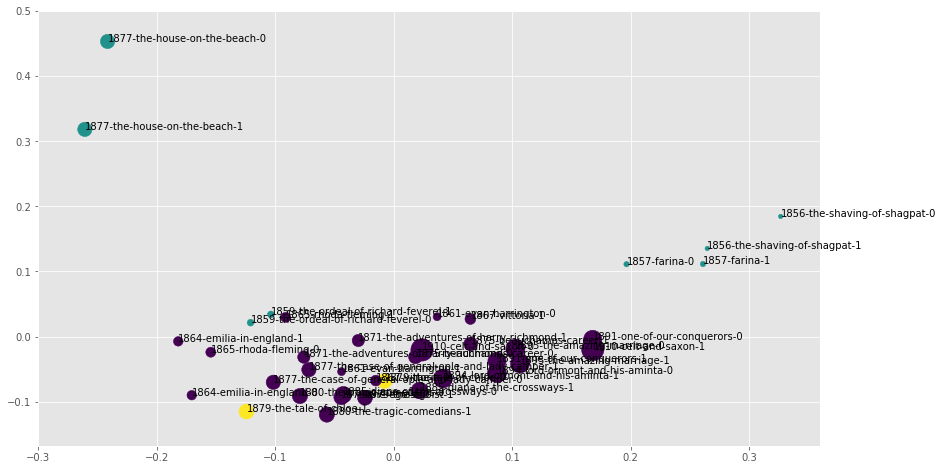

In [23]:
doAnalysis('meredith')

Using filenames:  ['data/cather-1923-a-lost-lady.txt', 'data/cather-1927-death-comes-for-the-archbishop.txt', 'data/cather-1940-sapphira-and-the-slave-girl.txt', 'data/cather-1915-the-song-of-the-lark.txt', 'data/cather-1912-alexanders-bridge.txt', 'data/cather-1935-lucy-gayheart.txt', 'data/cather-1913-o-pioneers.txt', 'data/cather-1918-my-ántonia.txt', 'data/cather-1931-shadows-on-the-rock.txt', 'data/cather-1925-the-professors-house.txt', 'data/cather-1926-my-mortal-enemy.txt', 'data/cather-1922-one-of-ours.txt']
Something went wrong. maxEnd is negative or zero.
                                              0         1         2         3  \
1913-o-pioneers-1                      0.021240  0.369712  0.261169 -0.005204   
1935-lucy-gayheart-0                   0.314745 -0.077305 -0.045280 -0.171940   
1923-a-lost-lady-1                    -0.075912 -0.284416  0.325770 -0.021020   
1935-lucy-gayheart-1                   0.280127 -0.074281 -0.049688 -0.176957   
1913-o-pioneers-0      

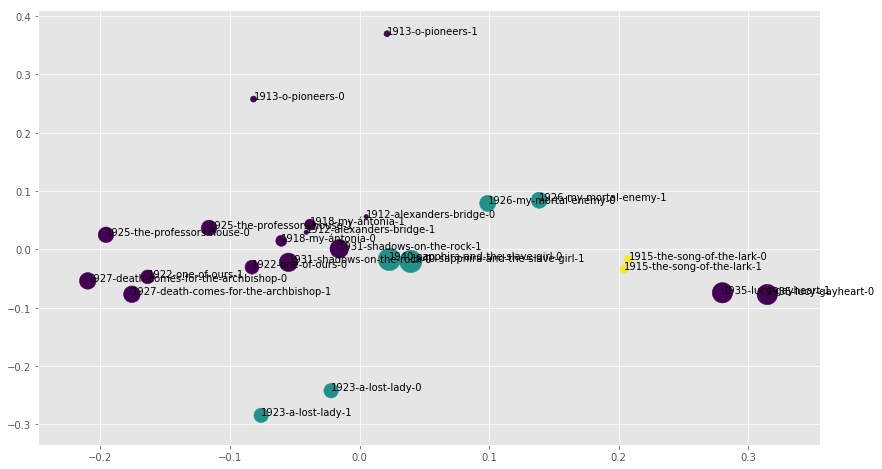

In [24]:
doAnalysis('cather')

Using filenames:  ['data/bennett-1923-riceyman.txt', 'data/bennett-1916-these-twain.txt', 'data/bennett-1928-strange-vanguard.txt', 'data/bennett-1929-accident.txt', 'data/bennett-1910-clayhanger.txt', 'data/bennett-1911-card.txt', 'data/bennett-1908-old-wives.txt', 'data/bennett-1930-imperial.txt', 'data/bennett-1902-anna.txt', 'data/bennett-1902-grand-babylon.txt']
Something went wrong. maxEnd is negative or zero.
                                0         1         2         3         4  \
1902-grand-babylon-1     0.345469 -0.173783 -0.039136 -0.104594 -0.013341   
1902-grand-babylon-0     0.335413 -0.149100 -0.039275 -0.110988 -0.014317   
1928-strange-vanguard-0  0.162426  0.183493 -0.017738  0.292616 -0.052417   
1910-clayhanger-1       -0.132291 -0.163237 -0.161992  0.062102 -0.053532   
1911-card-1             -0.075103 -0.174446  0.305577  0.074477  0.016008   
1911-card-0             -0.086004 -0.168891  0.258047  0.075993  0.028878   
1928-strange-vanguard-1  0.132994  0.1307

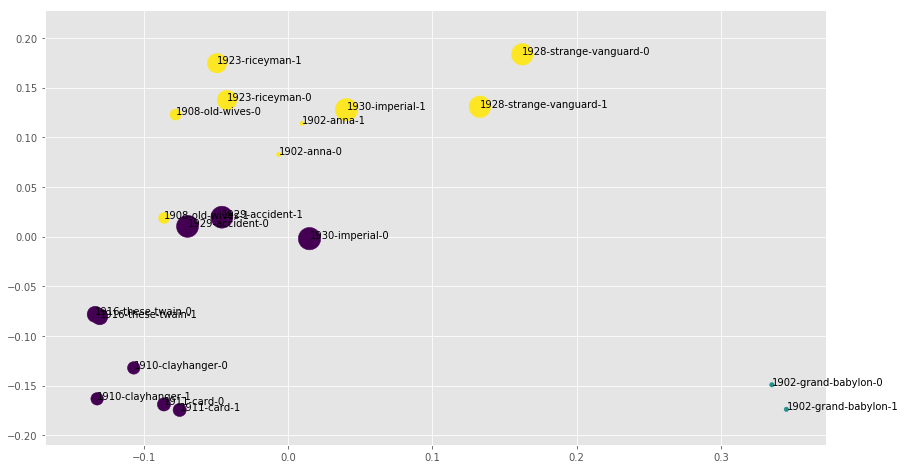

In [25]:
doAnalysis('bennett')